「TensorBoardを用いたモデル、データと訓練の可視化」
===============================================================
【原題】VISUALIZING MODELS, DATA, AND TRAINING WITH TENSORBOARD

【元URL】https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html

【翻訳】電通国際情報サービスISID AIトランスフォーメーションセンター　徳原 光

【日付】2020年11月27日

【チュトーリアル概要】

TensorBoardを用いることで、モデルの定義から訓練、評価までの一連の工程をブラウザの画面上で可視化することができます。

本チュートリアルではTensorBoardの持つ便利な機能を実行例を示しながら紹介していきます。

---


チュートリアル「[60 Minute Blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)」では、データの読み込み方法、`nn.Module`のサブクラスとして定義したモデルへのデータの入力の手法、訓練データを用いたモデルの訓練方法、そして、検証データを用いたテスト手法について解説してきました。

<br>

訓練時にモデルにいったい何が起こっているのか確認するために、モデルの統計データを画面上に表示することで、学習の進行状況を確認することができます。



さらに、PyTorchはTensorBoardと連携しており、ニューラルネットワークの訓練結果の可視化ツールとして利用することができるので、進捗確認以上の内容も表示が可能です。

本チュートリアルでは、Torchvision.datasetsから読み込むことができる、[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist)データセットを使用し、TensorBoardの機能の一部を解説します。



本チュートリアルでは、以下の5つの項目について解説します。

1.   データを読み込み、適切な変換を実施（前回のチュートリアルとほぼ同じ内容）
2.   TensorBoardのセットアップ
3.   TensorBoardへの書き込み
4.   TensorBoardによるモデル構造の解析
5.   TensorBoardを用いて、前回のチュートリアルよりも少ないコードで、インタラクティブ（対話的）な結果の表示を実現





特に、5番目の項目に関しては、



*   訓練データを精査する2つの方法
*   訓練時のモデルのパフォーマンスの追跡方法
*   訓練を終えたモデルのパフォーマンスの確認の仕方


について詳しく解説します。

---


（日本語訳注）

元の公式チュートリアルはGoogle Colaboratoryでの使用を想定しておらず、通常のJupyterNotebookでの使用方法の解説になっています。

日本語版の本チュートリアルではGoogle Colarboratoryで動作するよう、変更を加えています。

---

In [1]:
# Google ColabでTensorboardを使うための設定（今は不要）
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  print("エラー、やり直してください")
  pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
%load_ext tensorboard

変更追加、以上

---

[CIFAR-10のチュートリアル](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)で実装したモデルのコードを本チュートリアルで扱うモデルのひな型にします：

In [3]:
# imports
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# datasets
trainset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)

# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                        shuffle=True, num_workers=2)


testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# helper function to show an image
# (used in the `plot_classes_preds` function below)
# one_channel is grey channel. three_channel is color_channel
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

前回のチュートリアルとほぼ同じ構造の簡易的なモデルを定義しています。

画像のカラーチャネルが3チャネルではなく1チャネルであることと、サイズが32x32から28x28になっていることを考慮して、若干の変更を加えていきます：

<br>

（日本語訳注：CIFAR-10に収められている画像はカラー画像ですが、Fashion-MNISTの画像データはMNISTと同じくグレースケールで表されます）

## 学習したこと
1. 入力: 28*28
2. conv1通過後: 24*24
$$28 - 5 + 1 = 24$$
3. pool通過後: 12*12
4. conv2: 8*8
5. pool再び通過後: 4*4

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5) # (入力, 出力, カーネルサイズ)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

`optimizer`と`criterion`も以前と同じものを定義しておきます：

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

1.TensorBoardのセットアップ
============================

TensorBoardをセットアップし、`torch.utils`から`tensorboard`をインポートします。さらに、TenosorBoardに情報を書き込むための重要なオブジェクトである`SummaryWriter`を定義します。



In [6]:
from torch.utils.tensorboard import SummaryWriter

# デフォルトでは `log_dir` としていますが、今回は "runs" とさらに具体的な実験名まで記載します
writer = SummaryWriter('runs/fashion_mnist_experiment_1')

この一行を実行すると、フォルダ「`runs/fashion_mnist_experiment_1`」が作成されることに注意してください。

2.TensorBoardに書き込む
==============================

では、`make_grid`を使って画像をgridの変換しTensorBoardに書き込んでみましょう。

<br>

(日本語訳注：この手順を踏むことで、先ほど作成したファイル`runs/fashion_mnist_experiment_1`に画像のデータが保存され、TensorBoardがそれを読み込めるようになります）

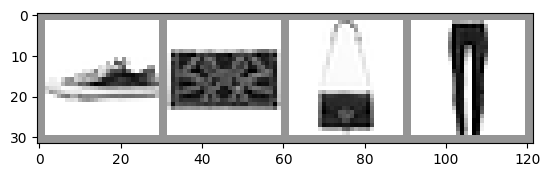

In [7]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_fashion_mnist_images', img_grid)

tensorboardを起動します。
```
tensorboard --logdir=runs
```
上のコマンドを実行環境のコマンドラインから実行し、ブラウザから http://localhost:6006 にアクセスすると、以下のように表示されるはずです。



（日本語訳注）

日本語版チュートリアルではGoogle Colabratory上に直接TensorBoardを表示させるため、ブラウザから http://localhost:6006 にアクセスするのではなく、以下のセルを実行してください。

表示されるまで少し時間がかかります。もし、表示内容が、

※No dashboards are active for the current data set.の場合は裏側の準備が整っていない状態です。

2分ほど待ってから、再度何度か、以下のセル

%tensorboard --logdir runs/fashion_mnist_experiment_1

を実行してください。


In [ ]:
%tensorboard --logdir runs/fashion_mnist_experiment_1

これで、TensorBoardの利用方法を確認できました。

この例はJupyter Notebook上でも実行可能です。

TensorBoardの優れている点はインタラクティブに情報を可視化できる点です。

本チュートリアルではそれらの優れた内容をいくつか紹介します。

まずは一つ目の機能について紹介したいと思います。

3.TensorBoardを使用してモデルを詳しく調べる
======================================

TensorBoardの強みは、複雑なモデル構造を可視化できるところにあります。

では、実際に構築したモデルを可視化してみましょう。


In [9]:
writer.add_graph(net, images)
writer.close()

コードを実行してTensorBoardを再読み込むと、メニュー上段（IMAGESの右）に「Graphs」タブが表示されます。

タブを選択した際に表示される「Net」と書かれた要素をダブルクリックすると、モデルNetを構成する個別の処理に関する、詳細情報（モデルのモジュール構成）を確認することができます。

In [ ]:
%tensorboard --logdir runs/fashion_mnist_experiment_1

その他にも、TensorBoardには画像といった、多次元のデータを低次元のグラフで表示するのに非常に便利な機能がありますので、続いてそちらを紹介します。

4.TensorBoardに“Projector”を追加する
==============================


add_embeddingメソッドを利用することで、高次元データを低次元の表現で可視化することができます。

In [11]:
# 日本語訳追記：本セルを追加しないと以下のセルでエラーが発生するため追加
# https://github.com/pytorch/pytorch/issues/30966
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
tf.io.gfile.join = lambda *args: '/'.join(args)

## torch.randperm()とは？
- 今回は`torch.randperm(data_length)`としているので、データのインデックス番号がシャッフルされている。のちにlabelsとdataで同じindexを使用しているので、labelsとdataはペア同士同じ順序で並んでいる必要がありこのメソッドはそれを前提としている。
- dataをpermで並び替えた後、先頭n件（今回は100件）取得している。

In [12]:
# helper function
#def select_n_random(data, labels, n=500):  # 日本語訳注：500は多いので減らす
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# select random images and their target indices
images, labels = select_n_random(trainset.data, trainset.targets)

# get the class labels for each image
class_labels = [classes[lab] for lab in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1)) # channel_one is grey img
writer.close()

TensorBoardの「Projector」タブでは、784次元の画像データが、3次元空間に投影されます。

さらに画面をドラッグすることで、3次元のグラフをインタラクティブに回転させることができます。



グラフを見やすくするためにちょっとしたヒントを紹介します。

左上の「color」の項目から「label」を選択し、上部メニューの「night mode」（三日月マークのボタン）をクリックすると、元の画像の背景が白なので画像がより見やすくなります。

<br>


※日本語訳注：以下のセルを実行しても「Projector」タブが表示されない場合は20～30分ほど待って、再度実行してください。画像をProjectorに追加する処理が重たいのでTensorBoardに反映されるまでに時間がかかります。

場合によっては本チュートリアルを最後まで進めてからここに戻ってくることをお勧めします（かなり時間がかかります）

それでも表示されない場合は、何度か以下のセルを繰り返し実行していると、うまく読み込んでくれます。。。


%tensorboard --logdir runs/fashion_mnist_experiment_1

ではなく、

%tensorboard --logdir runs/fashion_mnist_experiment_1/

だと描画がうまくいく場合もあります。。。（Google Colabのせいか、動作が不安定です）

In [ ]:
%tensorboard --logdir runs/fashion_mnist_experiment_1/

これで、すべてのデータを三次元空間にプロットすることができました。

<br>

では次に、TensorBoardで対象のモデルの訓練と評価をより簡便に解析する手法を解説します。

まず訓練過程を解析する方法から紹介します。

5.TensorBoardでモデルの訓練過程を解析する
=============================

前回の例では、イテレーションを2,000回繰り返すごとにモデルの損失を表示するだけでした。

代わりに、今回はTensorBoardでログを記録するのに加えて、`plot_classes_preds`を介してモデルの出力をまとめて表示させたいと思います。



In [14]:
# helper functions

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        # xticksとyticksを設定することによって、メモリを消している
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

最後に、前回のチュートリアルで使用したコードと同じコードを使ってモデルを訓練します。

それに加え、コンソールに損失を出力する代わりに、1,000バッチごとに`add_scalar`関数を使ってTensorBoardに損失の値を書き込みます。

さらに、訓練の際中に、バッチに含まれる4枚の画像に対する予測結果と実際のラベルをまとめた画像を作成します。

## TensorBoardで学習したこと
- SummaryWriter.add_scalar: 数値でグラフを記録するためのメソッド。
  - 第一引数: タグ名。TensorBoard上でのグラフのタイトルとなる。
  - 第二引数: 値（Y値）。
  - 第三引数: ステップ（X軸）。
- SummaryWriter.add_figure: 画像でグラフを記録するためのメソッド。
  - 第一引数: タグ名。
  - 第二引数: matplotlibで生成したfigureオブジェクトを指定する。今回は四つの画像を一つの画像にまとめた画像を貼り付ける関数を指定している。
  - 第三引数: ステップ

In [15]:
running_loss = 0.0
for epoch in range(1):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # every 1000 mini-batches...

            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(net, inputs, labels),
                            global_step=epoch * len(trainloader) + i)
            running_loss = 0.0
print('Finished Training')

Finished Training


「SCALARS」タブを開くと、0から15,000イタレーションの間の損失をプロットしたグラフが表示されています。

In [ ]:
%tensorboard --logdir runs/fashion_mnist_experiment_1

加えて、訓練中の任意のバッチに対するモデルが出力した予測値も見ることもできます。

「IMAGES」タブを開いて、「predictions vs. actuals」という項目で、**バーを下スクロールしてみてください**

**（画像がとても下の方に描画されています）。**

例えば、3,000イテレーション学習した後では、訓練終盤ほどの正解率ではありませんが、シャツ、スニーカー、コートのように視覚的に正しい画像のラベルをすでに識別できていることがわかります。

In [ ]:
%tensorboard --logdir runs/fashion_mnist_experiment_1

以前のチュートリアルでは、訓練が完了した後にラベルごとの識別精度をまとめていました。

TensorBoardを用いることで、各ラベルごとのprecision-recall曲線（PR曲線）を描くことができます（PR曲線の説明は、[こちら](https://www.scikit-yb.org/en/latest/api/classifier/prcurve.html)をご覧ください）。

# PR曲線
$$
Precision（適合率） = \frac{真陽性数（TP）}{真陽性数（TP）+偽陽性数（FP）}
$$
- 分母: モデルが「これは靴だ」と断言した全数。
- ニュアンス: モデルが「陽性」と判断した時の信頼度。
$$
Recall（再現率）=\frac{真陽性数（TP）}{真陽性数（TP）+ 偽陰性数（FN）}
$$
- 分母: データセットの中にある正解データの陽性の全数。
- ニュアンス: 正解をどれだけtrueと判断できたか

6.TensorBoardを使った学習モデルの評価
===============


## writer.add_pr_curve()
- 第一引数: タグ
- 第二引数: ラベル（正解と一致しているかのtensor）
- 第三引数: 確率（そのクラスである確率のtensor）


In [18]:
# 1. gets the probability predictions in a test_size x num_classes Tensor
# 2. gets the preds in a test_size Tensor
# takes ~10 seconds to run
class_probs = []
class_preds = []
log_count = 0
with torch.no_grad():
    for i, data in enumerate(testloader):
        images, labels = data
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]
        _, class_preds_batch = torch.max(output, 1)

        class_probs.append(class_probs_batch)
        class_preds.append(class_preds_batch)

        if log_count < 2:
          print(f"====test log {i+1}番目====")
          print("class_preds_batch:", class_preds_batch)
          print("class_preds:", class_preds)
          print("================")
          log_count += 1

# batch 単位でひとまとまりにした後にデータ単位でひとまとまりにしてる
# test_probsは確率が順番に入っている（データ数*クラス数特徴の2次元）
# test_predsはインデックスが順番に入っている。（1次元）
test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_preds = torch.cat(class_preds)

# helper function
def add_pr_curve_tensorboard(class_index, test_probs, test_preds, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_preds = test_preds == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_preds,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# plot all the pr curves
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_preds)

====test log 1番目====
class_preds_batch: tensor([9, 2, 1, 1])
class_preds: [tensor([9, 2, 1, 1])]
====test log 2番目====
class_preds_batch: tensor([6, 1, 4, 6])
class_preds: [tensor([9, 2, 1, 1]), tensor([6, 1, 4, 6])]


<br>

「PR Curves」タブを開くと、それぞれのラベルに対するPR曲線が表示されます。いくつかラベルに対してはほぼAUC（Area Under the Curve）が100%の大きさになっていることが分かりますが、この面積が小さいラベルも存在します。


## threshold（閾値）
- モデルがどのくらいの確率で判断したものを信用するかの閾値。高いほどPrecisionは高くなるがRecallは低くなる傾向がある。

In [ ]:
%tensorboard --logdir runs/fashion_mnist_experiment_1

以上、TensorBoardとPyTorchの連携方法の紹介チュートリアルでした。

TensorBoardの機能や描画内容は、どれもJupyter Notebook上で、TensorBordなしに実装して、実現は可能です。

ですが、本チュートリアルのようにTensorBoardを使えば、最初からインタラクティブにモデルの解析し、結果を可視化することができます。